<a href="https://colab.research.google.com/github/rowl27/Cancer-Omics/blob/main/01_05TCGA_BRECA_EXP_METH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries & notebook settings

In [2]:
#!pip install cyberpunk

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


import os # Standard library within Python 3
import numpy as np # Lib for multi-dimensional arrays and matrices handling
import pandas as pd # Lib for data manipulation and analysis
%matplotlib inline
import matplotlib.pyplot as plt # Lib for interactive plots
#plt.style.use('seaborn-white') # Sets theme of visualization (seaborn-ticks / whitegrid) are similar to white
import seaborn as sns # Matplotlib based lib - better interface for drawing attractive and informative statistical graphics
sns.set_palette(['#FC4B60','#06B1F0'])
random_seed = 63445
import warnings # Lib for warning issue handling
warnings.filterwarnings('ignore') # Ignores all irrelevant warnings
from collections import Counter
from sklearn import svm # SVM model for RFE Feature Selection
from sklearn.preprocessing import MinMaxScaler # Feature scaling
from sklearn.model_selection import train_test_split # Splitting data into training and test set
from imblearn.over_sampling import SMOTE # Oversample data using SMOTE algorithm
from sklearn.impute import SimpleImputer


import shap
#import cyberpunk
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cyberpunk_theme = {
    'axes.edgecolor': '0B2447',
    'axes.facecolor': '0B2447',
    'axes.labelcolor': 'white',
    'axes.titlecolor': 'white',
    'figure.facecolor': '0B2447',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray',
    'grid.linestyle': ':'
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class VAE(nn.Module):

    def __init__(self, input_dim=6561, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(torch.tensor(x ,dtype=torch.float32))
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

class omics():
    def __init__(self, path, kwrd,ref):
      self.path = path
      self.kwrd = kwrd
      self.ref = ref

    def get_geneexp(self):
      dt_gene = pd.read_csv(self.path + "exp", sep=' ', on_bad_lines='skip')
      dt_gene.index.names = ['PatientID']
      dat1 = np.transpose(dt_gene)
      d1 = dat1.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d1

    def get_mirna(self):
      dt_mirna  = pd.read_csv(self.path + "mirna",sep=' ',  on_bad_lines='skip')
      dat2 = np.transpose(dt_mirna)
      d2 = dat2.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d2

    def get_methy(self):
      df_methy = pd.read_csv(self.path + "methy",sep=' ',  on_bad_lines='skip')
      dat3 = np.transpose(df_methy)
      d3 = dat3.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d3

    def get_clinics(self):
      dt_clinics = pd.read_csv(self.path + self.kwrd ,sep='\t', on_bad_lines='skip')
      d0 = dt_clinics .drop_duplicates()
      d0 = d0[['sampleID','sample_type']]#
      d4=d0.replace(to_replace=["Primary Tumor","Solid Tissue Normal"],value=[self.ref,"0"])
      d4_dev=d4.rename(columns={"sampleID":"PatientID","sample_type":"Class"})
      d4_dev['PatientID']=d4_dev['PatientID'].str.replace('-','.')#.set_index('PatientID')
      d4_dev = d4_dev.set_index('PatientID')
      return d4_dev

    def get_multiomics(self):
      dframe1 = self.get_geneexp()
      dframe2 = self.get_mirna()
      dframe3 = self.get_methy()
      dframe4 = self.get_clinics()
      integrate = [dframe1,dframe2,dframe3,dframe4]
      return pd.concat(integrate, axis=1, join='inner')
    def get_meth_cl(self):

      dframe3 = self.get_methy()
      dframe4 = self.get_clinics()
      integrate = [dframe3,dframe4]
      return pd.concat(integrate, axis=1, join='inner')

    def get_gene_cl(self):

      dframe1 = self.get_geneexp()
      dframe4 = self.get_clinics()
      integrate = [dframe1,dframe4]
      return pd.concat(integrate, axis=1, join='inner')


def prep_loaders(features, target):
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)
  return train_loader, test_loader,x_train, x_test, y_train, y_test



def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x_shape = tuple(x.shape)
           # print(x_shape)
            batch_size = x_shape[0]
            x = x.type(torch.float32).view(x_shape).to(device)
            #x = x.view(x_shape).to(device)
            #x = x.view(batch_size, x_shape).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


Dataset Aggregation

In [3]:
root_path='/content/drive/MyDrive/DOC_UPM/datasets/'
omics_data ={'BRECA':{'local_path':'01_004_BRECA', 'kwrd':'breast','key':'2'},\
       'GBM': {'local_path':'01_005_GBM', 'kwrd':'gbm','key':'3'},\
        'LUSC': {'local_path':'01_003_LUSC','kwrd': 'lung','key':'1'},\
        'SRCM': {'local_path':'01_007_SRCM','kwrd': 'sarcoma','key':'4'},\
             'AML': {'local_path':'01_008_AML','kwrd': 'aml','key':'5'},\
             'LIVER': {'local_path':'01_006_LIVER','kwrd': 'liver','key':'6'}\

             }
#Cancer Included
cacer_list=['BRECA','GBM','LUSC','SRCM','AML','LIVER']

In [4]:
f1='BRECA'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
breca_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()
f1='LUSC'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
lusc_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()
f1='GBM'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
gbm_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()
f1='SRCM'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
srcm_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()
f1='AML'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
aml_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()
f1='LIVER'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
liver_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_multiomics()

In [5]:
inter_ca= [srcm_omics[srcm_omics['Class']!='Metastatic'],liver_omics[liver_omics['Class']!='Metastatic'],gbm_omics[gbm_omics['Class']!='Metastatic'],aml_omics[aml_omics['Class']!='Metastatic'],breca_omics[breca_omics['Class']!='Metastatic'],lusc_omics[lusc_omics['Class']!='Metastatic']]
df_pan=pd.concat(inter_ca, join="outer").reset_index()
df_pan = df_pan[~df_pan['Class'].isin(['Recurrent Tumor','Primary Blood Derived Cancer - Peripheral Blood','3','1','4','6'])]
#df_pan = df_pan[~df_pan['Class'].isin(['Recurrent Tumor','Primary Blood Derived Cancer - Peripheral Blood'])]
df_pan.shape


(724, 62823)

In [6]:
df_pan['Class'].value_counts()

,count
Class,
2,621
0,103


In [21]:
shap_con = pd.read_csv('/content/drive/MyDrive/DOC_UPM/datasets/01_004_BRECA/shap_con_breca.csv')
shap_con.head()

,Feature,Negativo,BRECA,tot
0,INADL.10207,0.084338,0.084338,0.084338
1,cg04892646,0.072526,0.072526,0.072526
2,FAM160B2.64760,0.065435,0.065435,0.065435
3,CHPF2.54480,0.063124,0.063124,0.063124
4,cg13546240,0.050278,0.050278,0.050278


In [7]:
#filter_list=list(shap_con['Feature'].head(1000))
#filter_list

Normalization and Missing Values Imputation

In [7]:
features = df_pan.drop(columns=['Class','index']) #Retrieves all rows (1:), leaves last column (,1:-1)
features=features.dropna(axis=1, how='all')#[filter_list]
target = df_pan['Class'].astype('int32') #Retrieves all rows (1:), leaves last column (,1:-1)
nfeatures=len(features.columns)
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
#Scaled feature
features = pd.DataFrame(min_max_scaler.fit_transform(features), columns=features.columns, index=features.index)
imputer = SimpleImputer(strategy='mean')
imputer.fit(features)
features_imputed = imputer.transform(features)
current_columns = features.columns
features = pd.DataFrame(features_imputed, columns=current_columns)



In [107]:
df_pan.sample(4)

,index,X..10357,X..10431,X..155060,X..57714,X..653553,X..8225,A1BG.1,A2LD1.87769,A2M.2,...,cg27527798,cg27529871,cg27538352,cg27546977,cg27553926,cg27577527,cg27583037,cg27623451,cg27633287,cg27649037
554,TCGA.ES.A2HT.11,96.7703,1376.0882,46.2346,226.9146,275.5826,697.1693,74612.7973,158.1832,335175.7645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1199,TCGA.A7.A6VX.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1253,TCGA.AO.A1KP.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1255,TCGA.AO.A1KR.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dimensionality Reduction

##### **Shap**

In [7]:
#Shap filering
##[filer_list]
features.shape

(724, 37545)

In [1]:
# Installing CUDA Toolkit (If not available or outdated)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
!mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub
!add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/ /"
!apt-get update
!apt-get -y install cuda-toolkit-11-0

# Check Installation
!nvcc --version

--2025-03-02 15:49:35--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 2.16.106.132, 2.16.106.152
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|2.16.106.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2004.pin’

cuda-ubuntu2004.pin 100%[===================>]     190  --.-KB/s    in 0s      

2025-03-02 15:49:35 (201 MB/s) - ‘cuda-ubuntu2004.pin’ saved [190/190]

Executing: /tmp/apt-key-gpghome.6dYaAp7OSA/gpg.1.sh --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub
gpg: requesting key from 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub'
gpg: key F60F4B3D7FA2AF80: "cudatools <cudatools@nvidia.com>" not changed
gpg: Total number processed: 1
gpg:              unchan

In [8]:
#!pip install cudf-cu11 --extra-index-url https://pypi.nvidia.com
import cudf

# Assuming 'features' is your pandas DataFrame
features_gpu = cudf.from_pandas(features)  # Move data to GPU

# Calculate the correlation matrix on the GPU
correlation_matrix_gpu = features_gpu.corr()

# Convert back to pandas DataFrame if needed
correlation_matrix = correlation_matrix_gpu.to_pandas()

RuntimeError: Failed to dlopen libcudart.so.11.0

In [ ]:
import pandas as pd
import numpy as np

# Calculate the correlation matrix
correlation_matrix = features.corr()




In [ ]:
# Filter for correlations above a certain threshold (e.g., 0.8)
threshold = 0.8
highly_correlated = correlation_matrix[np.abs(correlation_matrix) > threshold]


In [ ]:

correlated_pairs = []
for column in highly_correlated.columns:
    for index in highly_correlated.index:
        if column != index and highly_correlated.loc[index, column] != 0:
            correlated_pairs.append((column, index, highly_correlated.loc[index, column]))

correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

correlated_pairs_df['abs_correlation'] = np.abs(correlated_pairs_df['Correlation'])
correlated_pairs_df = correlated_pairs_df.sort_values(by=['abs_correlation'], ascending=False)


correlated_pairs_df.to_csv('correlated_variables.csv', index=False)

In [1]:
print(correlated_pairs_df)

NameError: name 'correlated_pairs_df' is not defined

##### **SVM Correlation**

In [8]:
#Set Parameter
C = 1.0
rfeIndex = nfeatures
#Create SVM model using a linear kernel
model = svm.SVC(kernel='linear', C=C).fit(features,target)
coef = model.coef_
coef.shape

(1, 37545)

In [9]:
 rfeIndex

37545

In [96]:

#Print co-efficients of features
#for i in range(0, nFeatures):
#	print (features.columns[i],":", coef[0][i])
#Find the minimum weight among features and eliminate the feature with the smallest weight
nFeatures= nfeatures
min1 = coef[0][0]

for j in range(12000): # To make sure only 12,000 features remain
  index = 0
  j+=1
  for i in range(0, rfeIndex): # Iterates until the final feature
	  if min1 > coef[0][i]:
		  index = index + 1
		  min1 = coef[0][i]

  if len(features.columns) == 1:
	  #print ("After recursive elimination we have the", features.columns[index], "feature with a score of:", min)
    at2=1
  else:
	  #print ("Lowest feature weight is for", features.columns[index], "with a value of:", min)
	  #print ("Dropping feature", features.columns[index])
	  features.drop(features.columns[index], axis = 1, inplace = True)
	  rfeIndex = rfeIndex - 1
	  nFeatures = nFeatures - 1

In [106]:
features.sample(4)

,cg04682802,cg04688351,cg04689606,cg04696181,cg04715503,cg04737131,cg04742780,cg04767174,cg04770020,cg04786287,...,cg27527798,cg27529871,cg27538352,cg27546977,cg27553926,cg27577527,cg27583037,cg27623451,cg27633287,cg27649037
81,0.489971,0.304384,0.891428,0.962180,0.775326,0.666508,0.036270,0.724100,0.715347,0.62571,...,0.439044,0.585424,0.60329,0.370882,0.57015,0.346942,0.493759,0.602204,0.453276,0.660552
488,0.131709,0.106766,0.891428,0.937141,0.011895,0.666508,0.053826,0.278666,0.715347,0.62571,...,0.439044,0.585424,0.60329,0.370882,0.57015,0.346942,0.493759,0.602204,0.453276,0.660552
422,0.387228,0.596173,0.891428,0.787749,0.870386,0.666508,0.230644,0.544949,0.715347,0.62571,...,0.439044,0.585424,0.60329,0.370882,0.57015,0.346942,0.493759,0.602204,0.453276,0.660552
146,0.641614,0.034751,0.891428,0.247661,0.862258,0.666508,0.043143,0.640068,0.715347,0.62571,...,0.439044,0.585424,0.60329,0.370882,0.57015,0.346942,0.493759,0.602204,0.453276,0.660552


SMOTE Balancing

Dataloaders Production

In [98]:
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_n = RandomForestClassifier(n_estimators=5, random_state=random_seed)
rf_n.fit(x_train, y_train)
y_pred= rf_n.predict(x_test)

explainer = shap.TreeExplainer(rf_n)
shap_values = explainer.shap_values(x_test)
feature_names = x_test.columns


X = pd.DataFrame(shap_values[:,:,0], columns = feature_names)
X1 = pd.DataFrame(shap_values[:,:,1], columns = feature_names)
X2 = pd.DataFrame(shap_values[:,:,2], columns = feature_names)
X3 = pd.DataFrame(shap_values[:,:,3], columns = feature_names)
X4 = pd.DataFrame(shap_values[:,:,4], columns = feature_names)

rf_resultX = pd.concat([X,X1,X2,X3,X4], axis=1)
vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
filer_list =shap_importance['col_name'].head(20000)

In [ ]:
x_test

,X..10357,X..10431,X..155060,X..57714,X..653553,X..8225,A1BG.1,A2LD1.87769,A2M.2,A4GALT.53947,...,cg27538352,cg27546977,cg27553926,cg27577527,cg27583037,cg27592331,cg27623451,cg27633287,cg27645259,cg27649037
567,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1324,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1631,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.460646,0.677230,0.684504,0.811570,0.017338,0.760510,0.299355,0.335235,0.018136,0.343955
115,0.352497,0.156482,0.045295,0.090760,0.007435,0.055608,0.189713,0.061949,0.074484,0.018168,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
453,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.354718,0.745298,0.252804,0.001602,0.028159,0.697594,0.724312,0.427979,0.016590,0.938279
277,0.078597,0.152623,0.061526,0.097989,0.055339,0.188868,0.213485,0.056247,0.049543,0.062027,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1320,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1569,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.991416,0.382739,0.587808,0.407970,0.640693,0.626473,0.389477,0.604402,0.041255,0.465196


In [28]:
import torch.optim as optim
model = VAE( input_dim=features.shape[1], hidden_dim=400, latent_dim=200, device=device).to(device)#[filer_list].
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
#Check device
device

device(type='cuda')

In [32]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        # Use train_loader instead of train
        for batch_idx, (x, _) in enumerate(train_loader):
            x_shape = tuple(x.shape)
            batch_size = x_shape[0]
            x = x.type(torch.float32).view(x_shape).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss
train(model, optimizer, epochs=100, device=device)

	Epoch 1 	Average Loss:  184.57201960057387
	Epoch 2 	Average Loss:  184.5970768869659
	Epoch 3 	Average Loss:  184.5371942402404
	Epoch 4 	Average Loss:  184.5159166124132
	Epoch 5 	Average Loss:  184.50582169897763
	Epoch 6 	Average Loss:  184.52221472469378
	Epoch 7 	Average Loss:  184.49490111551168
	Epoch 8 	Average Loss:  184.47727693157432
	Epoch 9 	Average Loss:  184.4904064602322
	Epoch 10 	Average Loss:  184.49967061737436
	Epoch 11 	Average Loss:  184.48659948655117
	Epoch 12 	Average Loss:  184.53498086811584
	Epoch 13 	Average Loss:  184.49706230634524
	Epoch 14 	Average Loss:  184.6492020406841
	Epoch 15 	Average Loss:  184.5056682633765
	Epoch 16 	Average Loss:  184.39317444224417
	Epoch 17 	Average Loss:  184.3878483713409
	Epoch 18 	Average Loss:  184.3833935584551
	Epoch 19 	Average Loss:  184.4210893607434
	Epoch 20 	Average Loss:  184.38977964424794
	Epoch 21 	Average Loss:  184.3565485448013
	Epoch 22 	Average Loss:  184.38420368712625
	Epoch 23 	Average Loss:  184

29793.943237304688

<Axes: xlabel='dim1', ylabel='dim2'>

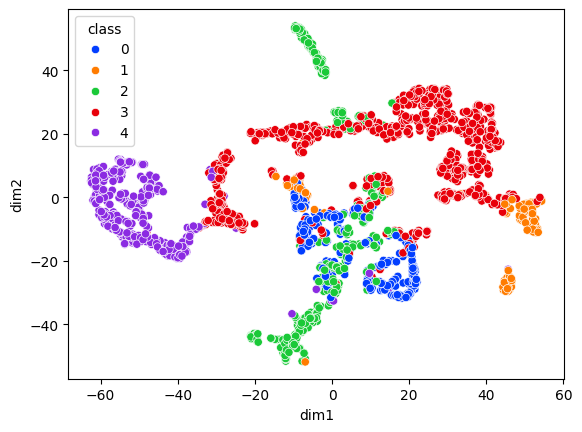

In [ ]:
from sklearn.manifold import TSNE
x_encoded = model.encode(torch.tensor(x_train.head(1).values, dtype=torch.float32).to(device))
x_hat, mean, logvar = model(torch.tensor(x_train.values, dtype=torch.float32).to(device))
embg200=x_hat.detach().cpu().numpy()
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(embg200)
toPlot=pd.DataFrame({'dim1':tsne_res[:, 0],'dim2':tsne_res[:, 1],'class':y_train})
import seaborn as sns
sns.scatterplot(data=toPlot, x="dim1", y="dim2", hue="class", palette='bright')

In [33]:
x_encoded = model.encode(torch.tensor(x_test.values, dtype=torch.float32).to(device))
x_hat, mean, logvar = model(torch.tensor(x_test.values, dtype=torch.float32).to(device))
embg200=x_hat.detach().cpu().numpy()

<Axes: xlabel='dim1', ylabel='dim2'>

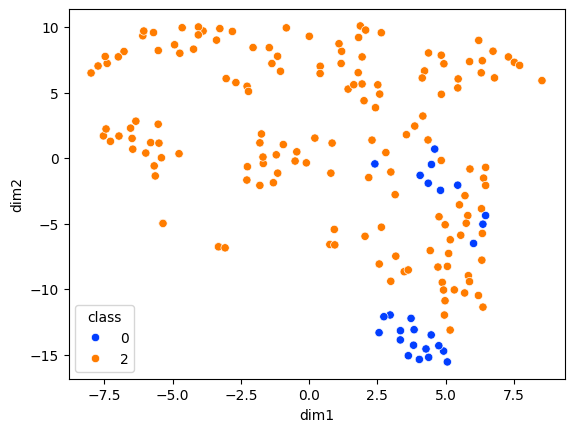

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(embg200)
toPlot=pd.DataFrame({'dim1':tsne_res[:, 0],'dim2':tsne_res[:, 1],'class':y_test.values})
import seaborn as sns
sns.scatterplot(data=toPlot, x="dim1", y="dim2", hue="class", palette='bright')

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=5, random_state=random_seed)
# Move x_hat and y_test_tensor to CPU before converting to NumPy arrays
rf.fit(x_hat.cpu().detach().numpy(), y_test_tensor.cpu().detach().numpy())

y_pred= rf.predict(x_hat.cpu().detach().numpy())
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9945
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           2       1.00      0.99      1.00       155

    accuracy                           0.99       181
   macro avg       0.98      1.00      0.99       181
weighted avg       0.99      0.99      0.99       181



NOT VAE

In [99]:
# Assuming x_train, y_train, x_test, and y_test are already defined
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Create LightGBM dataset
train_data = lgb.Dataset(x_train, label=y_train_encoded)
test_data = lgb.Dataset(x_test, label=y_test_encoded)

# Set parameters for LightGBM
params = {
    'objective': 'multiclass',  # Assuming multi-class classification
    'num_class': len(np.unique(y_train)),  # Number of classes
    'metric': 'multi_logloss',  # Evaluation metric
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'num_leaves': 31,  # Number of leaves in each tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Feature fraction for each tree
    'class_weight': 'unbalanced'
}

# Train the LightGBM model
num_round = 100  # Number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions on the test set
y_pred = bst.predict(x_test, num_iteration=bst.best_iteration)
y_pred = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test_encoded, y_pred)
print(report)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.369520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3224307
[LightGBM] [Info] Number of data points in the train set: 543, number of used features: 19442
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.953304
[LightGBM] [Info] Start training from score -0.152924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf_n = RandomForestClassifier(n_estimators=5, random_state=random_seed)
rf_n.fit(x_train, y_train)
y_pred= rf_n.predict(x_test)
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9945
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           2       0.99      1.00      1.00       155

    accuracy                           0.99       181
   macro avg       1.00      0.98      0.99       181
weighted avg       0.99      0.99      0.99       181



Shap

In [100]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)
feature_names = x_test.columns


In [101]:
shap_values .shape

(181, 25545, 2)

Text(0.5, 1.0, 'SHAP interaction effect - Clase BRECA')

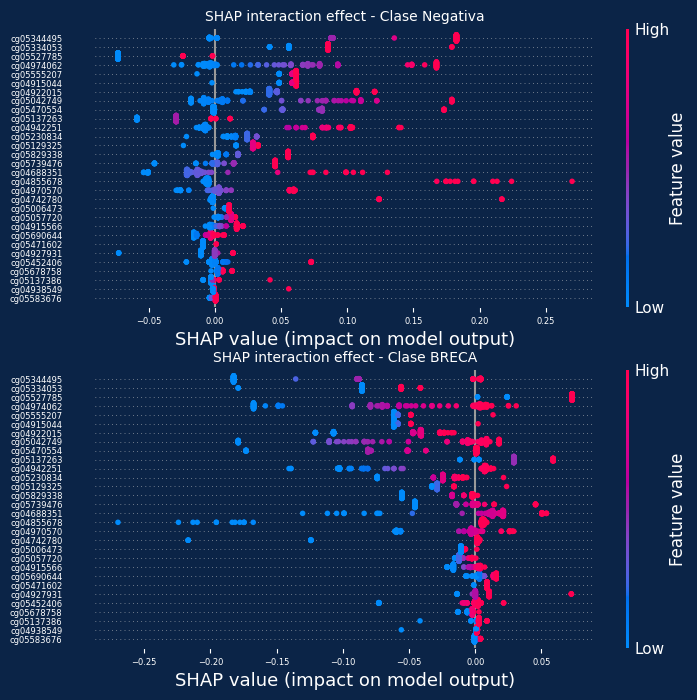

In [102]:
plt.style.use(cyberpunk_theme)
fig = plt.figure(tight_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)  # Ajustado a una sola fila para visualización en paralelo

ax1 = fig.add_subplot(spec[0, 0])  # ax1 en la primera columna
shap.summary_plot(shap_values[:, :, 0], features=shap_values[:, :, 0], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white', labelsize=6)
ax1.tick_params(axis='y', colors='white', labelsize=6)
ax1.set_title(f'SHAP interaction effect - Clase Negativa', fontsize=10)  # Título para ax1

ax2 = fig.add_subplot(spec[1, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 1], features=shap_values[:, :, 1], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax2.yaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white', labelsize=6)
ax2.tick_params(axis='y', colors='white', labelsize=6)
ax2.set_title(f'SHAP interaction effect - Clase BRECA', fontsize=10)  # Título para ax2



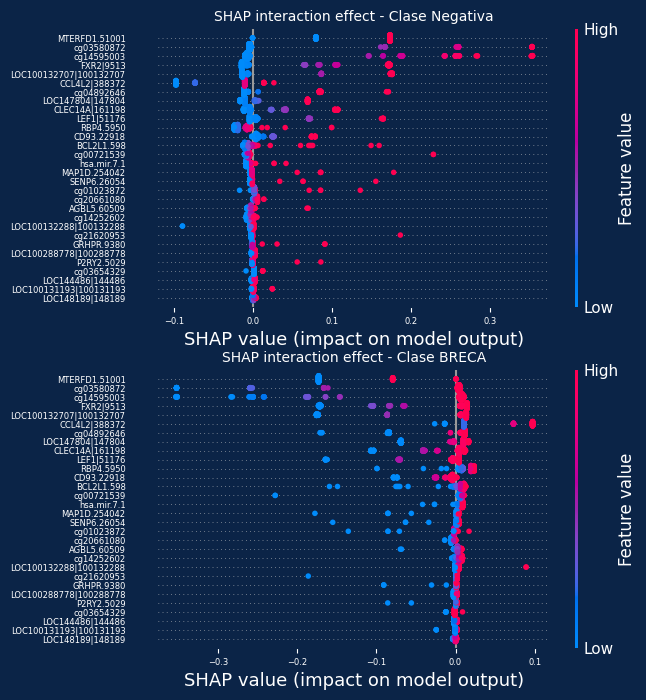

In [38]:
plt.style.use(cyberpunk_theme)
fig = plt.figure(tight_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)  # Ajustado a una sola fila para visualización en paralelo

ax1 = fig.add_subplot(spec[0, 0])  # ax1 en la primera columna
shap.summary_plot(shap_values[:, :, 0], features=shap_values[:, :, 0], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white', labelsize=6)
ax1.tick_params(axis='y', colors='white', labelsize=6)
ax1.set_title(f'SHAP interaction effect - Clase Negativa', fontsize=10)  # Título para ax1

ax2 = fig.add_subplot(spec[1, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 1], features=shap_values[:, :, 1], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax2.yaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white', labelsize=6)
ax2.tick_params(axis='y', colors='white', labelsize=6)
ax2.set_title(f'SHAP interaction effect - Clase BRECA', fontsize=10)  # Título para ax2



plt.show()

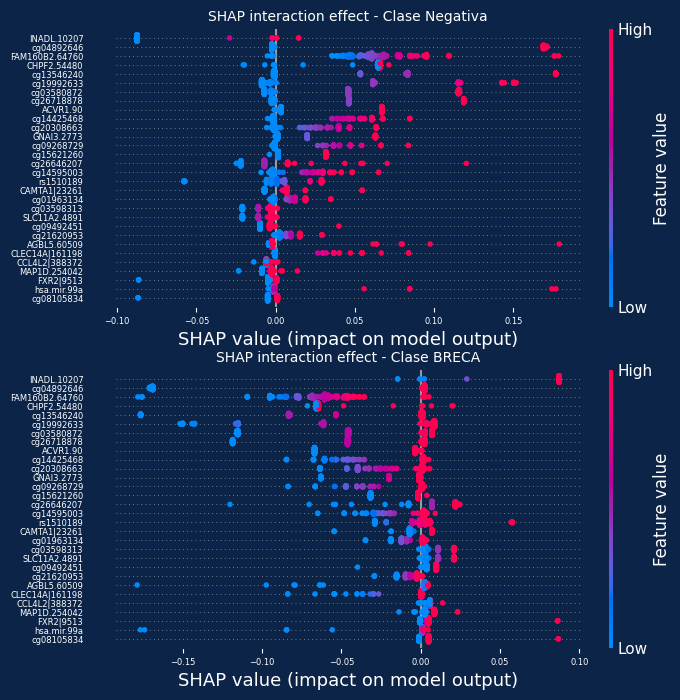

In [36]:
plt.style.use(cyberpunk_theme)
fig = plt.figure(tight_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)  # Ajustado a una sola fila para visualización en paralelo

ax1 = fig.add_subplot(spec[0, 0])  # ax1 en la primera columna
shap.summary_plot(shap_values[:, :, 0], features=shap_values[:, :, 0], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white', labelsize=6)
ax1.tick_params(axis='y', colors='white', labelsize=6)
ax1.set_title(f'SHAP interaction effect - Clase Negativa', fontsize=10)  # Título para ax1

ax2 = fig.add_subplot(spec[1, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 1], features=shap_values[:, :, 1], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax2.yaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white', labelsize=6)
ax2.tick_params(axis='y', colors='white', labelsize=6)
ax2.set_title(f'SHAP interaction effect - Clase BRECA', fontsize=10)  # Título para ax2



plt.show()


In [93]:
import pandas as pd

# Calcular el promedio absoluto de los valores de SHAP para cada feature y clase
mean_abs_shap_class1 = np.mean(np.abs(shap_values[:, :, 0]), axis=0)
mean_abs_shap_class2 = np.mean(np.abs(shap_values[:, :, 1]), axis=0)



# Crear un DataFrame con los promedios absolutos
shap_df_mean_abs = pd.DataFrame({
    'Negativo': mean_abs_shap_class1,

    'BRECA': mean_abs_shap_class2,

}, index=x_test.columns)

# Renombrar el índice a 'Feature'
shap_df_mean_abs.index.name = 'Feature'

# Mostrar el DataFrame resultante
df1 = shap_df_mean_abs.sort_values(by='Negativo', ascending=False)['Negativo'].head(1000)
df2 = shap_df_mean_abs.sort_values(by='BRECA', ascending=False)['BRECA'].head(1000)


In [94]:
df2=df2.reset_index()
df2.head(10)

,Feature,BRECA
0,ABCC1.4363,0.204867
1,ABAT.18,0.178574
2,ABHD12.26090,0.134706
3,ABCA1.19,0.103921
4,ABCF1.23,0.071744
5,ABLIM1.3983,0.070993
6,ABCB1.5243,0.056083
7,ABCD1.215,0.040954
8,ABCC9.10060,0.029168
9,X..10431,0.021119


In [77]:
df2=df2.reset_index()
df2.head(10)

,Feature,BRECA
0,MTERFD1.51001,0.142553
1,cg03580872,0.066145
2,cg14595003,0.064297
3,FXR2|9513,0.059477
4,LOC100132707|100132707,0.054100
5,CCL4L2|388372,0.047048
6,cg04892646,0.034000
7,LOC147804|147804,0.028263
8,CLEC14A|161198,0.021840
9,LEF1|51176,0.019382


In [78]:
df2[df2['Feature']=='MTERFD1.51001']

,Feature,BRECA
0,MTERFD1.51001,0.142553


In [38]:
df2.head(10)

,BRECA
Feature,
INADL.10207,0.084338
cg04892646,0.072526
FAM160B2.64760,0.065435
CHPF2.54480,0.063124
cg13546240,0.050278
cg19992633,0.049170
cg03580872,0.038848
cg26718878,0.037369
ACVR1.90,0.034627


In [47]:
import pandas as pd

# Calcular el promedio absoluto de los valores de SHAP para cada feature y clase
mean_abs_shap_class1 = np.mean(np.abs(shap_values[:, :, 0]), axis=0)
mean_abs_shap_class2 = np.mean(np.abs(shap_values[:, :, 1]), axis=0)


# Crear un DataFrame con los promedios absolutos
shap_df_mean_abs = pd.DataFrame({
    'Negativo': mean_abs_shap_class1,
    'BRECA': mean_abs_shap_class2,

}, index=x_test.columns)

# Renombrar el índice a 'Feature'
shap_df_mean_abs.index.name = 'Feature'
shap_df_mean_abs['tot']=shap_df_mean_abs.median(axis=1)


In [34]:
shap_con= shap_df_mean_abs.sort_values(by='tot', ascending=False).head(100)

In [44]:
shap_con.to_csv('/content/drive/MyDrive/DOC_UPM/datasets/01_004_BRECA/shap_con_breca.csv')

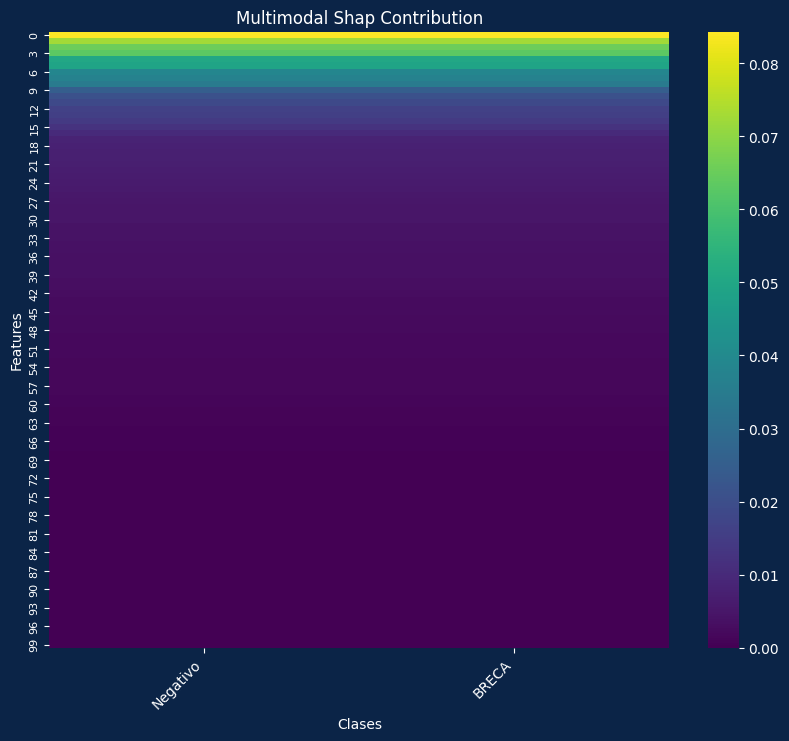

In [49]:
shap_con = shap_con.reset_index()

# Select only the numerical columns (SHAP values) for the heatmap
numerical_shap_con = shap_con[['Negativo', 'BRECA']]

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_shap_con, annot=False, cmap='viridis', fmt=".2f")

plt.title('Multimodal Shap Contribution')
plt.xlabel('Clases')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # Adjust fontsize as needed
plt.xticks(rotation=45, ha='right')
plt.show()

In [50]:
shap_interaction = explainer.shap_interaction_values(x_test.values.astype(np.float32))

In [56]:
shap_interaction.shape

(181, 100, 100, 2)

In [64]:
shap_interaction = shap_interaction.astype(np.float32)

mean_shap = np.abs(shap_interaction[:,:,:,1]).mean(0)
mean_shap

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06338955, 0.        , ..., 0.00038145, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00038145, 0.        , ..., 0.00396023, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [70]:

df2 = pd.DataFrame(mean_shap, index=x_test.columns, columns=x_test.columns)
df2['var'] = df2.index
df2.head()
df2.reset_index().head()
#df2=df2.drop(['index'], axis=1)
df_melt= df2.melt(id_vars=['var']).sort_values('value', ascending=False)
df_melt[df_melt['var']!=df_melt['Feature']].drop_duplicates('value').head(50)

,var,Feature,value
2585,LOC147804|147804,CCL4L2|388372,0.039664
6601,cg04892646,MTERFD1.51001,0.028079
2448,CD93.22918,CLEC14A|161198,0.013388
1585,LOC147804|147804,cg14595003,0.012886
6637,cg00721539,MTERFD1.51001,0.009340
675,LOC100132707|100132707,cg03580872,0.009016
664,LEF1|51176,cg03580872,0.008208
4238,BCL2L1.598,RBP4.5950,0.007378
2715,cg14595003,FXR2|9513,0.006965
2724,CLEC14A|161198,FXR2|9513,0.005685


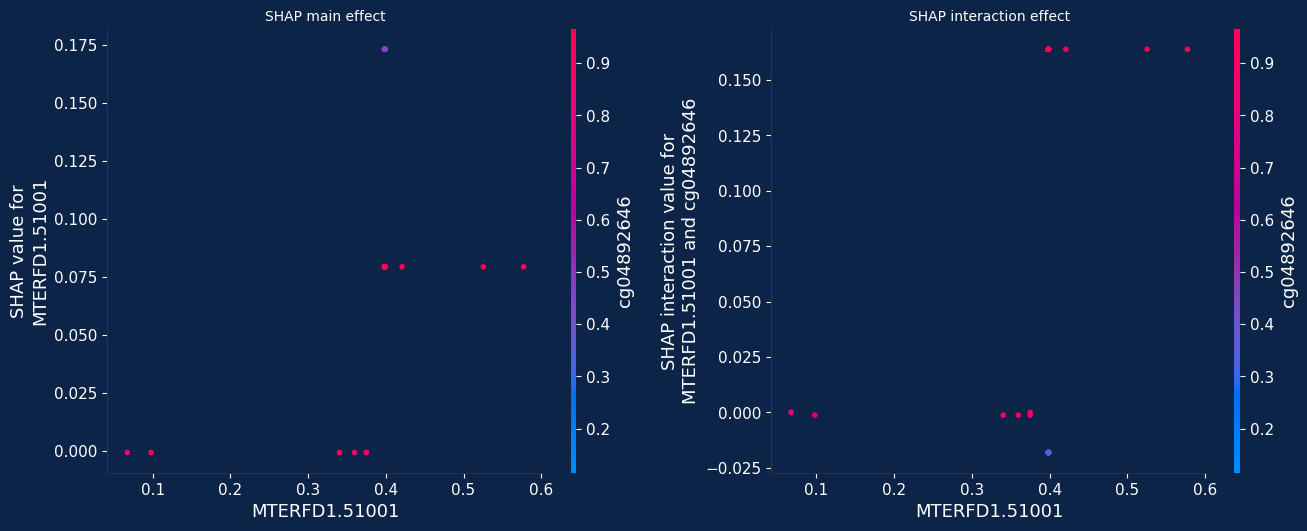

In [74]:

    plt.style.use(cyberpunk_theme)
    X_sampled=x_test
    f2='cg04892646'
    f1='MTERFD1.51001'#'R_sum(log12)'
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    minv, maxv = np.percentile(X_sampled, [1, 99])
#    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=f2, ax=ax0, show=False)
    shap.dependence_plot(f1, shap_values[:, :, 0], X_sampled, display_features=X_sampled, interaction_index=f2, ax=ax0, show=False)

    ax0.yaxis.label.set_color('white')
    ax0.xaxis.label.set_color('white')
    ax0.tick_params(axis='x', colors='white')
    ax0.tick_params(axis='y', colors='white')
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction[:,:,:,1], X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')
    ax1.xaxis.label.set_color('white')
    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')
    ax1.set_title(f'SHAP interaction effect', fontsize=10)


    plt.show()